In [108]:
'''
Author: jonnyzhang02 71881972+jonnyzhang02@users.noreply.github.com
Date: 2023-05-10 17:59:58
LastEditors: jonnyzhang02 71881972+jonnyzhang02@users.noreply.github.com
LastEditTime: 2023-05-15 01:12:31
FilePath: \cv_hw_2\main.ipynb
Description: coded by ZhangYang@BUPT, my email is zhangynag0207@bupt.edu.cn

Copyright (c) 2023 by zhangyang0207@bupt.edu.cn, All Rights Reserved. 
'''

'\nAuthor: jonnyzhang02 71881972+jonnyzhang02@users.noreply.github.com\nDate: 2023-05-10 17:59:58\nLastEditors: jonnyzhang02 71881972+jonnyzhang02@users.noreply.github.com\nLastEditTime: 2023-05-15 01:12:31\nFilePath: \\cv_hw_2\\main.ipynb\nDescription: coded by ZhangYang@BUPT, my email is zhangynag0207@bupt.edu.cn\n\nCopyright (c) 2023 by zhangyang0207@bupt.edu.cn, All Rights Reserved. \n'

# Step0：导入相关的库

In [109]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pickle

# Step 1: 训练数据处理，提取SIFT特征

### 读取文件，训练数据处理

In [110]:
def load_images_from_folder(folder):
    images = [] # 存储所有图像
    for filename in os.listdir(folder): # 遍历文件夹中的每个图像
        img = cv2.imread(os.path.join(folder, filename)) # 读取图像
        if img is not None: # 如果图像读取成功
            images.append(img) # 将图像添加到images中
    return images # 返回所有图像

In [111]:
# Load training images
train_images = [] # 存储所有训练图像
train_labels = [] # 存储所有训练图像的标签
for category in os.listdir("./15-Scene/"):  
    temp = load_images_from_folder("./15-Scene/" + category)[:150] # 读取每个类别的150后的图像
    train_images += temp # 读取每个类别的所有图像
    for i in range(len(temp)):
        train_labels.append(int(category)) # 为每个测试图像添加标签

print("训练图像数量: ", len(train_images))
print("训练图像标签数量: ", len(train_labels))

训练图像数量:  2250
训练图像标签数量:  2250


###  为每个图像提取SIFT特征

In [112]:
def extract_sift_features(X):
    image_descriptors = [] # 存储所有图像的SIFT特征
    sift = cv2.SIFT_create()  # 创建SIFT对象
    for i in range(len(X)): # 提取每张图像的SIFT特征
        if i % 100 == 0:
            print("正在提取第", i, "张图像的SIFT特征...")
        kp, des = sift.detectAndCompute(X[i], None) # kp为关键点，des为描述子
        image_descriptors.append(des) # 将每张图像的描述子添加到image_descriptors中
    return image_descriptors # 返回所有图像的SIFT特征

In [113]:
# 为每个图像提取SIFT特征
train_descriptors = extract_sift_features(train_images)
print("训练图像的SIFT特征提取完毕！")
print("第一张训练图像的SIFT特征矩阵形状: ", train_descriptors[0].shape)
print("说明它有",train_descriptors[0].shape[0],"个特征点，每个特征点有",train_descriptors[0].shape[1],"个特征值")

正在提取第 0 张图像的SIFT特征...
正在提取第 100 张图像的SIFT特征...
正在提取第 200 张图像的SIFT特征...
正在提取第 300 张图像的SIFT特征...
正在提取第 400 张图像的SIFT特征...
正在提取第 500 张图像的SIFT特征...
正在提取第 600 张图像的SIFT特征...
正在提取第 700 张图像的SIFT特征...
正在提取第 800 张图像的SIFT特征...
正在提取第 900 张图像的SIFT特征...
正在提取第 1000 张图像的SIFT特征...
正在提取第 1100 张图像的SIFT特征...
正在提取第 1200 张图像的SIFT特征...
正在提取第 1300 张图像的SIFT特征...
正在提取第 1400 张图像的SIFT特征...
正在提取第 1500 张图像的SIFT特征...
正在提取第 1600 张图像的SIFT特征...
正在提取第 1700 张图像的SIFT特征...
正在提取第 1800 张图像的SIFT特征...
正在提取第 1900 张图像的SIFT特征...
正在提取第 2000 张图像的SIFT特征...
正在提取第 2100 张图像的SIFT特征...
正在提取第 2200 张图像的SIFT特征...
训练图像的SIFT特征提取完毕！
第一张训练图像的SIFT特征矩阵形状:  (257, 128)
说明它有 257 个特征点，每个特征点有 128 个特征值


###  将所有描述子垂直堆积在一个numpy数组中

In [114]:
print("正在堆叠描述子...")
descriptors_list = list(train_descriptors[0])  # 将第一个描述子转换为列表
for descriptor in train_descriptors[1:]:  # 从第二个描述子开始
    descriptors_list.extend(descriptor)  # 将描述子添加到列表中
descriptors = np.array(descriptors_list)  # 将列表转换为 numpy 数组
print("描述子堆叠完毕！")
print(descriptors.shape) # 打印描述子数组的形状，以确保正确堆叠

正在堆叠描述子...
描述子堆叠完毕！
(1133764, 128)


# Step 2: 使用KMeans对特征进行聚类，创建视觉词袋

### 对特征聚类

In [115]:
import faiss

n_clusters = 150
niter = 20
verbose = True
# 对数据进行预处理，Faiss需要float32类型的数据
descriptors = np.array(descriptors).astype('float32')
# 初始化KMeans对象
kmeans = faiss.Kmeans(descriptors.shape[1], n_clusters, niter=niter, verbose=verbose)
# 进行KMeans聚类
kmeans.train(descriptors)
# 获取聚类中心
centroids = kmeans.centroids
# 使用聚类模型进行预测
D, I = kmeans.index.search(descriptors, 1)


In [116]:
# # sklearn太慢了，用faiss
# kmeans = KMeans(n_clusters = 150) #希望得到150个视觉词
# print("开始对特征聚类...")
# kmeans.fit(descriptors)
# print("特征聚类完毕！")

# # 将kmeans对象保存到文件中
# with open('kmeans.pkl', 'wb') as f:
#     pickle.dump(kmeans, f) 

In [117]:
print(D.shape)
print(D[0])
print(I.shape)
print(I[0])

(1133764, 1)
[109905.69]
(1133764, 1)
[122]


### 为每个图像创建特征向量

In [118]:
print("正在为图像创建特征向量...")
train_features = [] # 存储所有图像的特征向量 
for i in range(len(train_images)): 
    if i % 100 == 0:
        print("正在为第", i, "张图像创建特征向量...")
    histogram = np.zeros(150) # 初始化特征向量
    D, I = kmeans.index.search(train_descriptors[i], 1)
    for w in I:
        histogram[w] += 1 # 计算每个视觉词的直方图
    train_features.append(histogram) # 将每个图像的特征向量添加到train_features中

正在为图像创建特征向量...
正在为第 0 张图像创建特征向量...
正在为第 100 张图像创建特征向量...
正在为第 200 张图像创建特征向量...
正在为第 300 张图像创建特征向量...
正在为第 400 张图像创建特征向量...
正在为第 500 张图像创建特征向量...
正在为第 600 张图像创建特征向量...
正在为第 700 张图像创建特征向量...
正在为第 800 张图像创建特征向量...
正在为第 900 张图像创建特征向量...
正在为第 1000 张图像创建特征向量...
正在为第 1100 张图像创建特征向量...
正在为第 1200 张图像创建特征向量...
正在为第 1300 张图像创建特征向量...
正在为第 1400 张图像创建特征向量...
正在为第 1500 张图像创建特征向量...
正在为第 1600 张图像创建特征向量...
正在为第 1700 张图像创建特征向量...
正在为第 1800 张图像创建特征向量...
正在为第 1900 张图像创建特征向量...
正在为第 2000 张图像创建特征向量...
正在为第 2100 张图像创建特征向量...
正在为第 2200 张图像创建特征向量...


In [119]:
print("特征向量创建完毕！")
print("第一张图像的特征向量: ", train_features[0])

特征向量创建完毕！
第一张图像的特征向量:  [ 3.  3.  1.  2.  0.  2. 15.  2.  3.  1.  1.  0.  1.  3.  4.  0.  2.  3.
  1.  1.  3.  1.  2.  2.  3.  0.  0.  0.  0.  3.  2.  2.  4.  6.  7.  3.
  4.  2.  2.  0.  1.  2.  0.  0.  0.  1.  4.  0.  0.  2.  0.  1.  6.  5.
  1.  2.  0.  1.  3.  0.  0.  1.  3.  1.  0.  1.  1.  3.  1.  0.  9.  1.
  3.  1.  1.  3.  1.  2.  1.  2.  2.  0.  1.  1.  1.  1.  2.  1.  2.  3.
  2.  2.  3.  2.  1.  9.  1.  1.  0.  1.  1.  1.  0.  4.  0.  3.  1.  0.
  0.  0.  0.  3.  2.  1.  0.  5.  2.  2.  2.  1.  1.  0.  2.  1.  0.  0.
  2.  1.  1.  0.  1.  0.  1.  1.  1.  0.  2.  1.  2.  3.  0.  2.  0.  2.
  1.  1.  3.  1.  2.  3.]


# Step 3: 标准化特征向量

In [120]:
scaler = StandardScaler().fit(train_features) #
train_features = scaler.transform(train_features)

In [121]:
# with open('train_features.pkl', 'wb') as f:
#     pickle.dump(train_features, f) # 将train_features对象保存到文件中

# Step 4: 使用SVM进行训练

In [122]:
svm = SVC()
svm.fit(train_features, train_labels)

with open('svm.pkl', 'wb') as f:
    pickle.dump(svm, f) # 将svm对象保存到文件中

# Step 5: 对测试数据集进行同样的处理并进行预测

In [123]:
# svm = pickle.load(open('svm.pkl', 'rb'))

In [124]:
# 读取测试图像
test_images = []
test_labels = []
for category in os.listdir("./15-Scene/"):  
    temp = load_images_from_folder("./15-Scene/" + category)[151:] # 读取每个类别的150后的图像
    test_images += temp # 读取每个类别的所有图像
    for i in range(len(temp)):
        test_labels.append(int(category)) # 为每个测试图像添加标签

print("测试图像读取完毕！")
print("测试图像数量: ", len(test_images))
print("测试图像标签数量: ", len(test_labels))

test_descriptors = extract_sift_features(test_images) # 提取测试图像的SIFT特征

# 为测试图像创建特征向量
test_features = []
for i in range(len(test_images)): 
    histogram = np.zeros(150) # 初始化特征向量
    D, I = kmeans.index.search(train_descriptors[i], 1)
    for w in I:
        histogram[w] += 1 # 计算每个视觉词的直方图
    test_features.append(histogram) # 将每个图像的特征向量添加到train_features中

# 正则化特征向量
test_features = scaler.transform(test_features) # 

# 使用SVM进行预测
test_predictions = svm.predict(test_features) # 

测试图像读取完毕！
测试图像数量:  2250
测试图像标签数量:  2250
正在提取第 0 张图像的SIFT特征...
正在提取第 100 张图像的SIFT特征...
正在提取第 200 张图像的SIFT特征...
正在提取第 300 张图像的SIFT特征...
正在提取第 400 张图像的SIFT特征...
正在提取第 500 张图像的SIFT特征...
正在提取第 600 张图像的SIFT特征...
正在提取第 700 张图像的SIFT特征...
正在提取第 800 张图像的SIFT特征...
正在提取第 900 张图像的SIFT特征...
正在提取第 1000 张图像的SIFT特征...
正在提取第 1100 张图像的SIFT特征...
正在提取第 1200 张图像的SIFT特征...
正在提取第 1300 张图像的SIFT特征...
正在提取第 1400 张图像的SIFT特征...
正在提取第 1500 张图像的SIFT特征...
正在提取第 1600 张图像的SIFT特征...
正在提取第 1700 张图像的SIFT特征...
正在提取第 1800 张图像的SIFT特征...
正在提取第 1900 张图像的SIFT特征...
正在提取第 2000 张图像的SIFT特征...
正在提取第 2100 张图像的SIFT特征...
正在提取第 2200 张图像的SIFT特征...


# Step 6: 评价

In [125]:
print(train_labels)
print(test_labels)
print(test_predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

(2250,)
(2250,)
准确率： 0.8128888888888889
召回率： 0.8128888888888889
精确率： 0.8236556923804976


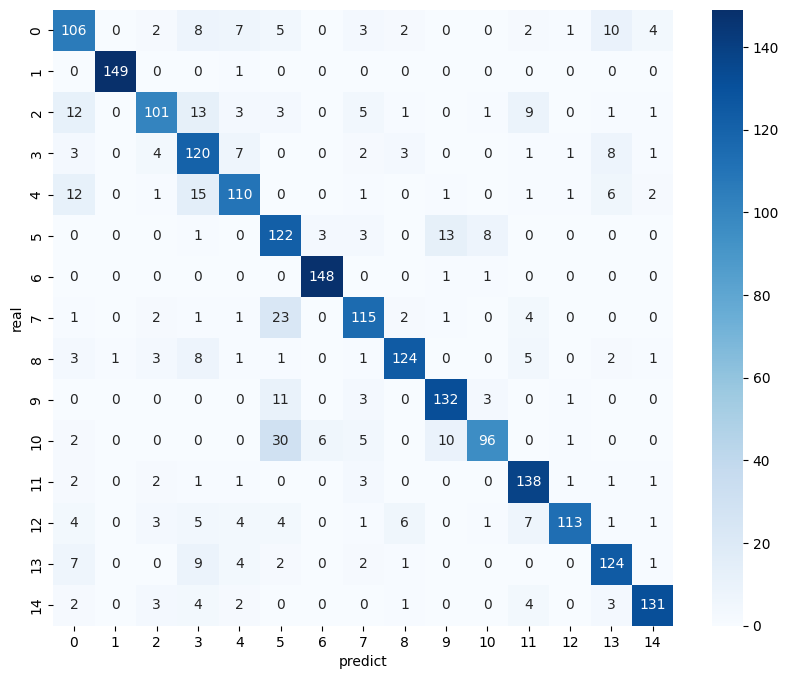

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
test_labels = np.array(test_labels)
print(test_labels.shape)
print(test_predictions.shape)


accuracy = accuracy_score(test_labels, test_predictions)
print("准确率：", accuracy)

# 计算召回率
recall = recall_score(test_labels, test_predictions, average='macro')
print("召回率：", recall)

# 计算精确率
precision = precision_score(test_labels, test_predictions, average='macro')
print("精确率：", precision)

# 计算混淆矩阵
cm = confusion_matrix(test_labels, test_predictions)

# 绘制混淆矩阵热图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("predict")
plt.ylabel("real")
plt.show()


